## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果

In [1]:
import os
from tensorflow import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization, Activation
def build_mlp(input_shape, output_units = 10, num_neurons=[512, 256, 128], pre_activate=False):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)

    for i,n_units in enumerate(num_neurons):
        if i ==0:
            x = keras.layers.Dense(units=n_units,
                                   name = 'hidden_layer' + str(i+1))(input_layer)
            if pre_activate:
                x = BatchNormalization()(x)
                x = Activation('relu')(x)
            else:
                x = Activation('relu')(x)
                x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units,
                                   name = 'hidden_layer' + str(i+1))(x)
            if pre_activate:
                x = BatchNormalization()(x)
                x = Activation('relu')(x)
            else:
                x = Activation('relu')(x)
                x = BatchNormalization()(x)
                
    out = keras.layers.Dense(units=output_units, activation='softmax', name = 'output')(x)

    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
MOMENTUM = 0.95
Batch_size = [2, 16, 32, 128, 256]
PRE_ACTIVATE = [True, False]

In [9]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""

for batch_size,pre_act in itertools.product(Batch_size,PRE_ACTIVATE):
    print(f'Experiment with batch-size :{batch_size}, pre_activate :{pre_act}')
    model = build_mlp(input_shape=x_train.shape[1:], pre_activate = pre_act)
    model.summary()
    optimizer = keras.optimizers.SGD(lr = LEARNING_RATE, momentum=MOMENTUM, nesterov=True)
    model.compile(loss = 'categorical_crossentropy', metrics=['accuracy'], optimizer = optimizer)

    model.fit(x_train,y_train,
              epochs=EPOCHS,
              batch_size=batch_size,
              validation_data=(x_test,y_test),
              shuffle=True)
    

    #Collect the results

    exp_name_tag = (f'Pre_active:{pre_act},Batch_size:{batch_size}')
    results[exp_name_tag] ={'train-loss': model.history.history["loss"],
                            'valid-loss': model.history.history["val_loss"],
                            'train-acc': model.history.history["accuracy"],
                            'valid-acc': model.history.history["val_accuracy"]}

Experiment with batch-size :2, pre_activate :True
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 batch_normalization_6 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 512)               0         
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 batch_normalization_7 (Batc  (None, 256)              1024      
 hNormali

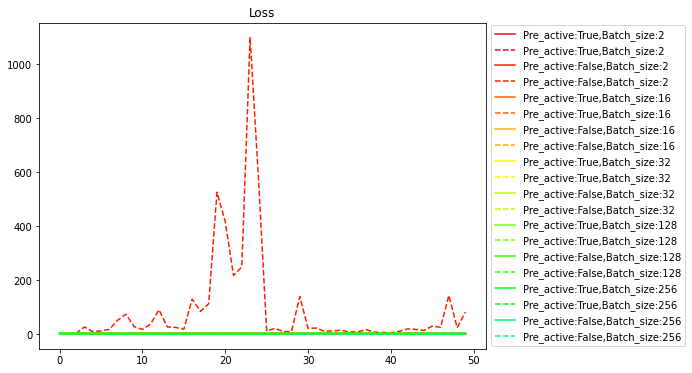

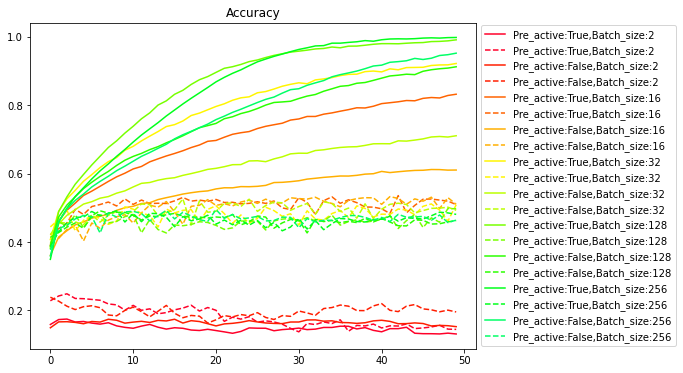

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
"""Code Here
將結果繪出
"""
NUM_COLORS = 20

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()